# Settings

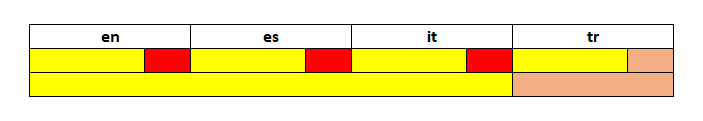

In [1]:
# CONTROLS
MODEL_PREFIX = "V03"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

TRAIN_SPLIT_RATIO = 0.2
BATCH_SIZE = 16
PREDICT_BATCH_SIZE = 256
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.2

NUM_EPOCHS = [2]
LR = 5e-5
MAX_SEQ_LEN = 75
SAMPLE_SIZE = 3000

RUN_ON_SAMPLE = 0

In [2]:
PATH = ".." #"/content/drive/My Drive/Kaggle/jigsaw-multilingual-toxic-comment-classification"

RESULTS_DIR = PATH+"/results/"
DATA_DIR = PATH+"/data/"
EXT_MODEL_DIR = PATH+"/"

if MODEL_NAME == 'xlm':
    MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
else:
    MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 12345
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Thu Jun 18 13:23:19 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


In [7]:
#if not os.path.exists(MODEL_DIR):
#    os.makedirs(MODEL_DIR)
#
#if not os.path.exists(DATA_DIR):
#    os.makedirs(DATA_DIR)
#
#if not os.path.exists(RESULTS_DIR):
#    os.makedirs(RESULTS_DIR)

<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [8]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [10]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')

In [11]:
train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [12]:
print(train.columns)
print(validation.columns)
print(test.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')


In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)

In [16]:
data = pd.concat([train[REQ_COLS].sample(SAMPLE_SIZE, random_state=seeded_value),
                  validation[REQ_COLS]], axis=0)

In [17]:
data.shape

(11000, 5)

In [18]:
data.sample(2)

,id,set,text,lang,toxic
6034,6034,valid,Ciao. La voce Tokyo Mew Mew - Amiche vincenti era stata spostata in modo errato (con copia e incolla) e io ho tentato di rimettere tutto a posto recuperando la cronologia. Potresti per favore dare un occhiata per vedere se adesso va bene? Non vorrei che si fosse perduta qualche recente tua modifica (alla fine le voci erano diventate 3 con le rispettive cronologie) -( Ciao e grazie. Lepido (msg),it,0
3724,3724,valid,Venerdì sera. tattica retorica abusata e piuttosto squallida il dire sempre con questa storia? . L hai usata per giustificare il tuo essere inutilmente parolaio. La usi adesso su una faccenda nuova nuova. Quando crescerai? JollyRoger ۩ lo sceriffo,it,1


In [19]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set   lang                
train en    3000  0.091333
valid es    2500  0.168800
      it    2500  0.195200
      tr    3000  0.106667

In [20]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [21]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# XLM Roberta Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [22]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [23]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [24]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [25]:
def sample_data(data, SAMPLE_SIZE, MAX_SEQ_LEN, valid_lang):
    
    data_valid = data.loc[data['lang'] == valid_lang]
    data_valid = data_valid.copy()
    data_valid = data_valid.reset_index(drop=True)
    
    data_train = data.loc[data['lang'] != valid_lang]
    data_train = data_train.copy()
    data_train = data_train.reset_index(drop=True)

    X_tokens_train, X_att_train = [], []
    for t in data_train.text.tolist():
        encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
        X_tokens_train.append(encoded_text['input_ids'])
        X_att_train.append(encoded_text['attention_mask'])

    X_tokens_train, X_att_train = np.array(X_tokens_train), np.array(X_att_train)
    Y_toxic_train = data_train['toxic'].values

    X_tokens_valid, X_att_valid = [], []
    for t in data_valid.text.tolist():
        encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
        X_tokens_valid.append(encoded_text['input_ids'])
        X_att_valid.append(encoded_text['attention_mask'])

    X_tokens_valid, X_att_valid = np.array(X_tokens_valid), np.array(X_att_valid)
    Y_toxic_valid = data_valid['toxic'].values

    return X_tokens_train, X_att_train, Y_toxic_train, X_tokens_valid, X_att_valid, Y_toxic_valid

In [26]:
X_tokens_train, X_att_train, Y_toxic_train, X_tokens_valid, X_att_valid, Y_toxic_valid = sample_data(data, SAMPLE_SIZE, MAX_SEQ_LEN, valid_lang='en')

print("\n \t Training Sample\n",
      X_tokens_train.shape, "\t: X_tokens_train ", "\n",
      X_att_train.shape, "\t: X_att_train ", "\n",
      Y_toxic_train.shape, "\t: Y_toxic_train ", "\n",
      "\n \t Validation Sample\n",
      X_tokens_valid.shape, "\t: X_tokens_valid ", "\n",
      X_att_valid.shape, "\t: X_att_valid ", "\n",
      Y_toxic_valid.shape, "\t: Y_toxic_valid ", "\n",
)


 	 Training Sample
 (8000, 75) 	: X_tokens_train  
 (8000, 75) 	: X_att_train  
 (8000,) 	: Y_toxic_train  
 
 	 Validation Sample
 (3000, 75) 	: X_tokens_valid  
 (3000, 75) 	: X_att_valid  
 (3000,) 	: Y_toxic_valid  



In [27]:
X_tokens_test, X_att_test = [], []
for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])

X_tokens_test, X_att_test = np.array(X_tokens_test), np.array(X_att_test)

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 75) 	: X_tokens_test  
 (63812, 75) 	: X_att_test  



# Model Specifications

In [28]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR) # TFDistilBertForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    return model

In [29]:
# def build_model():
#     input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
#     input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
#     if MODEL_NAME == 'xlm':
#         config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
#         model = transformers.TFXLMRobertaForSequenceClassification.from_pretrained(MODEL_DIR, config=config)
#         x = model(inputs=input_sequences, attention_mask=input_att_flags)
#     else:
#         config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
#         model = transformers.TFDistilBertForSequenceClassification.from_pretrained(MODEL_DIR)
#         x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
#     x1 = tf.keras.layers.Dense(1)(x[0])
#     toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
#     model = Model([input_att_flags, input_sequences],
#                   [toxic_output])
    
#     return model

In [30]:
model = build_model()

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 75)]         0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 75)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 75, 768),)   134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 75, 768)      0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [32]:
pred_test = np.zeros((len(X_tokens_test), 1))
timings_dict = {}

In [33]:
for num, valid_lang in enumerate(data.lang.unique()):
    print("================== Fold:", num, "Valid_Lang:", valid_lang," ==================")
    start_time = time()
    X_tokens_train, X_att_train, Y_toxic_train, X_tokens_valid, X_att_valid, Y_toxic_valid = sample_data(data,
                                                                                                         SAMPLE_SIZE,
                                                                                                         MAX_SEQ_LEN,
                                                                                                         valid_lang=valid_lang)
    
    if num>0:
        del model
        del mcp
        del csvl
        del adam
        del history
        del auc
        gc.collect()
        K.clear_session()

    model = build_model()
    auc = tf.keras.metrics.AUC()
    mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5", monitor='val_auc',
                          verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
    csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+valid_lang+"_"+str(num)+".csv",
                     separator=",", append=True)

    model.layers[3].trainable = False
    adam = Adam(learning_rate=LR)
    model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
                  optimizer=adam,
                  metrics=['accuracy', auc])
    
    train_time = time()
    history = model.fit(x={"att_flags":X_att_train,
                           "words":X_tokens_train},
                        y={"toxic_output":Y_toxic_train},
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS[0],
                        validation_data=({"att_flags":X_att_valid,
                                          "words":X_tokens_valid},
                                         {"toxic_output":Y_toxic_valid}),
                        verbose=1,
                        callbacks=[mcp, csvl])
    
    infer_time = time()
    # Loading best weights per fold
    model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5")

    pred_train = model.predict(x = {"att_flags":X_att_train,
                                    "words":X_tokens_train},
                               batch_size=PREDICT_BATCH_SIZE)

    pred_valid = model.predict(x = {"att_flags":X_att_valid,
                                    "words":X_tokens_valid},
                               batch_size=PREDICT_BATCH_SIZE)
    
    print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic_train, y_score=pred_train), "\n",
          "Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic_valid, y_score=pred_valid))
    
    print(classification_report(y_true=Y_toxic_train, y_pred=np.where(pred_train>0.5,1,0)))
    print(classification_report(y_true=Y_toxic_valid, y_pred=np.where(pred_valid>0.5,1,0)))
    
    # Accumulate test results after training every fold
    pred_test += model.predict(x = {"att_flags":X_att_test,
                                   "words":X_tokens_test},
                              batch_size=PREDICT_BATCH_SIZE)
    end_time = time(); timings_dict.update({num:{
        'start_time' : start_time,
        'train_time' : train_time,
        'infer_time' : infer_time,
        'end_time' : end_time,
    }});

================== Fold: 0 Valid_Lang: en  ==================
Train on 8000 samples, validate on 3000 samples
Epoch 1/2
8000/8000 [==============================] - 109s 14ms/sample - loss: 0.5003 - accuracy: 0.8531 - auc: 0.7730 - val_loss: 0.4325 - val_accuracy: 0.9170 - val_auc: 0.8537
Epoch 2/2
8000/8000 [==============================] - 99s 12ms/sample - loss: 0.4329 - accuracy: 0.9072 - auc: 0.9270 - val_loss: 0.4308 - val_accuracy: 0.9190 - val_auc: 0.8622
Train ROC-AUC:	 0.9926596294027933 
 Valid ROC-AUC:	 0.8622282856087099
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6770
           1       0.95      0.76      0.84      1230

    accuracy                           0.96      8000
   macro avg       0.95      0.87      0.91      8000
weighted avg       0.96      0.96      0.95      8000

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2726
           1       0.58

In [35]:
timings_dict

{0: {'end_time': 1592467358.6075065},
 1: {'end_time': 1592467804.1110487},
 2: {'end_time': 1592468250.4353774},
 3: {'end_time': 1592468669.9073637}}

In [41]:
test['toxic'] = pred_test/float(data.lang.nunique())

In [42]:
test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)

In [34]:
print(ctime(time()))

Thu Jun 18 13:54:29 2020
